In [63]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
# Set visual style
sns.set(style="whitegrid")

In [64]:
trader_df = pd.read_csv('Historical_data.csv')  
sentiment_df = pd.read_csv('fear_greed_index.csv')  

In [44]:
print('trader data:')
print (trader_df.head())

trader data:
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   
3       142.98   1142.04  BUY  02-12-2024 22:50     1146.558564       Buy   
4         8.73     69.75  BUY  02-12-2024 22:50     1289.488521       Buy   

   Closed PnL                                   Transaction Hash     Order ID  \
0         

In [45]:
print ('setiment data:')
print (sentiment_df.head())

setiment data:
    timestamp  value classification        date
0  1517463000     30           Fear  2018-02-01
1  1517549400     15   Extreme Fear  2018-02-02
2  1517635800     40           Fear  2018-02-03
3  1517722200     24   Extreme Fear  2018-02-04
4  1517808600     11   Extreme Fear  2018-02-05


In [65]:
# Converting to datetime and normalize
trader_df['Timestamp'] = pd.to_datetime(trader_df['Timestamp'])
trader_df['date'] = trader_df['Timestamp'].dt.normalize()

sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
sentiment_df['date'] = sentiment_df['date'].dt.normalize()

# Check for common dates
common_dates = set(trader_df['date']).intersection(set(sentiment_df['date']))
print(f"Common dates found: {len(common_dates)}")

# Merge only if common dates exist
if len(common_dates) > 0:
    merged_df = pd.merge(trader_df, sentiment_df, on='date', how='inner')
    print(f"Merged dataset size: {merged_df.shape}")
else:
    print("No common dates found. Please verify your date ranges and formats.")


Common dates found: 0
No common dates found. Please verify your date ranges and formats.


In [66]:
# Converting timestamp columns to datetime
trader_df['Timestamp'] = pd.to_datetime(trader_df['Timestamp'])
trader_df['date'] = trader_df['Timestamp'].dt.normalize()
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
sentiment_df['date'] = sentiment_df['date'].dt.normalize()

In [67]:
# Sorting both datasets for asof merge
trader_df = trader_df.sort_values('date')
sentiment_df = sentiment_df.sort_values('date')

In [68]:
#Merging with Nearest Previous Sentiment Date
merged_df = pd.merge_asof(trader_df, sentiment_df, on='date', direction='backward')

print(f"\n✅ Merged Dataset Size: {merged_df.shape}")
print(merged_df.head())


✅ Merged Dataset Size: (211224, 20)
                                      Account      Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed      @107          7.97690   
1  0x28736f43f1e871e6aa8b1148d38d4994275d72c4       ENA          0.39656   
2  0x28736f43f1e871e6aa8b1148d38d4994275d72c4       ENA          0.39293   
3  0x28736f43f1e871e6aa8b1148d38d4994275d72c4       ETH       2086.10000   
4  0x28736f43f1e871e6aa8b1148d38d4994275d72c4  FARTCOIN          0.54572   

   Size Tokens  Size USD  Side     Timestamp IST  Start Position   Direction  \
0       986.87   7872.16   BUY  02-12-2024 22:50             0.0         Buy   
1        90.00     35.69  SELL  24-03-2025 11:02          2092.0  Close Long   
2       450.00    176.82  SELL  24-03-2025 14:19          2002.0  Close Long   
3         0.50   1043.05  SELL  24-03-2025 14:19             6.0  Close Long   
4        20.10     10.97  SELL  24-03-2025 14:52          -446.6  Open Short   

   Closed PnL            

In [69]:
# Adding win/loss flag
merged_df['win'] = merged_df['Closed PnL'] > 0

In [70]:
# Cleaning sentiment labels
merged_df['classification'] = merged_df['classification'].str.strip().str.capitalize()

In [71]:
# Grouping by sentiment and calculate performance metrics
performance_summary = merged_df.groupby('classification').agg({
    'Closed PnL': ['mean', 'median', 'sum'],
    'Size USD': 'mean',
    'win': 'mean',
    'Fee': 'mean'
}).reset_index()


In [53]:
# Rename columns for easier reference
performance_summary.columns = ['Sentiment', 'AvgPnL', 'MedianPnL', 'TotalPnL', 'AvgSizeUSD', 'WinRate', 'AvgFee']

print("\n📊 Performance Summary by Sentiment:")
print(performance_summary)


📊 Performance Summary by Sentiment:
Empty DataFrame
Columns: [Sentiment, AvgPnL, MedianPnL, TotalPnL, AvgSizeUSD, WinRate, AvgFee]
Index: []


In [54]:
print(merged_df['classification'].value_counts(dropna=False))


classification
NaN    211224
Name: count, dtype: int64


In [72]:
# Droping rows where sentiment is missing
plot_df = merged_df.dropna(subset=['classification'])


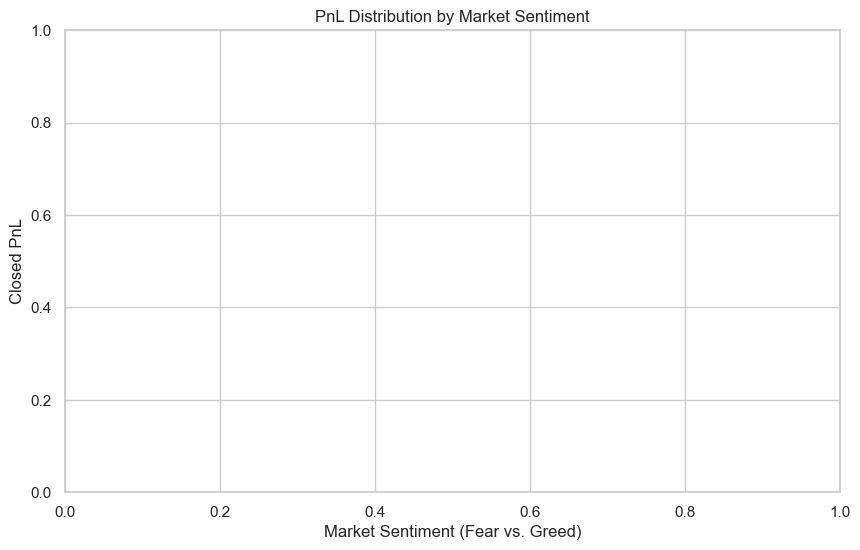

In [56]:
# Boxplot: PnL by Sentiment
plt.figure(figsize=(10,6))
sns.boxplot(x='classification', y='Closed PnL', data=plot_df)
plt.title('PnL Distribution by Market Sentiment')
plt.ylabel('Closed PnL')
plt.xlabel('Market Sentiment (Fear vs. Greed)')
plt.show()


In [57]:
# Cleaning missing sentiment rows
plot_df = merged_df.dropna(subset=['classification'])

# Checking sentiment distribution
print(plot_df['classification'].value_counts())

# Plot if data exists
if plot_df['classification'].nunique() > 0:
    plt.figure(figsize=(10,6))
    sns.boxplot(x='classification', y='Closed PnL', data=plot_df)
    plt.title('PnL Distribution by Market Sentiment')
    plt.ylabel('Closed PnL')
    plt.xlabel('Market Sentiment (Fear vs. Greed)')
    plt.show()
else:
    print("Not enough sentiment data available to plot.")


Series([], Name: count, dtype: int64)
Not enough sentiment data available to plot.


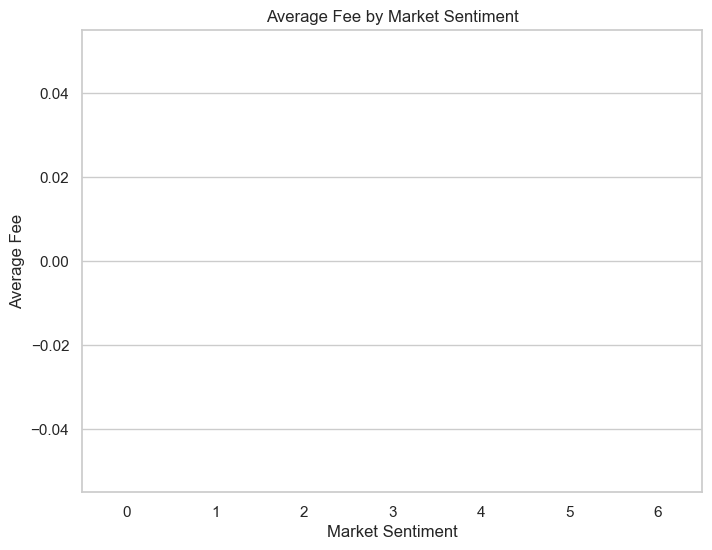

In [58]:
# Barplot: Average Fee by Sentiment
plt.figure(figsize=(8,6))
sns.barplot(x='classification', y='Fee', data=merged_df)
plt.title('Average Fee by Market Sentiment')
plt.ylabel('Average Fee')
plt.xlabel('Market Sentiment')
plt.show()

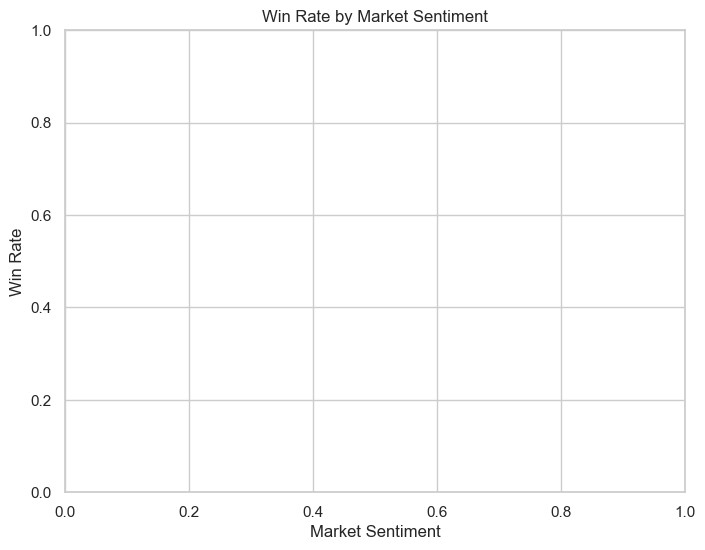

In [59]:
# Barplot: Win Rate by Sentiment
plt.figure(figsize=(8,6))
sns.barplot(x='Sentiment', y='WinRate', data=performance_summary)
plt.title('Win Rate by Market Sentiment')
plt.ylabel('Win Rate')
plt.xlabel('Market Sentiment')
plt.show()

C:\Users\sumiti08\AppData\Local\Temp\ipykernel_17244\3465317583.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Market Sentiment')


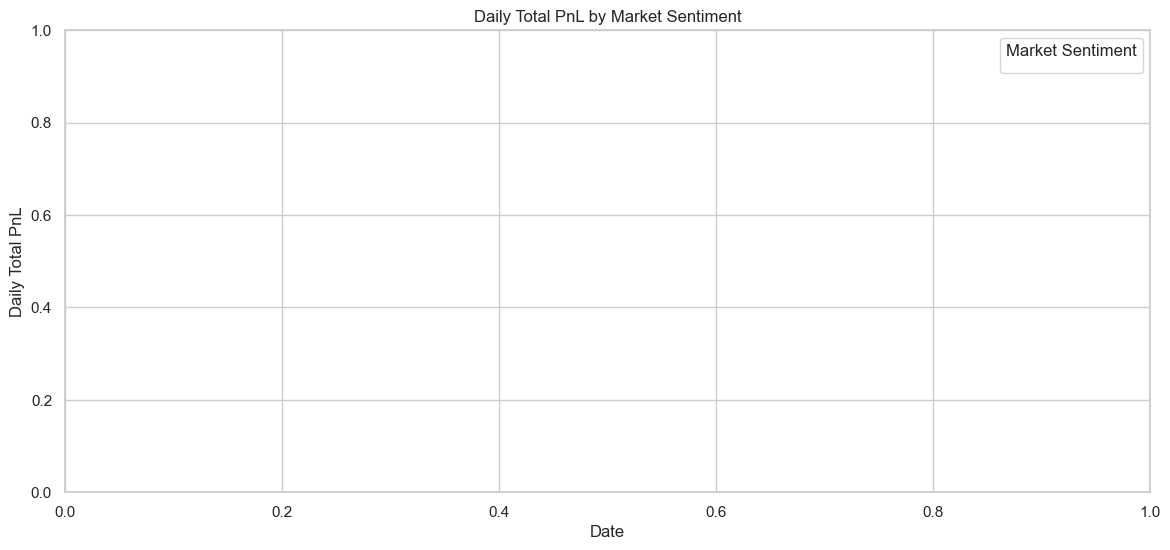

In [60]:
 #Lineplot: Daily Total PnL by Sentiment
daily_pnl = merged_df.groupby(['date', 'classification'])['Closed PnL'].sum().reset_index()

plt.figure(figsize=(14,6))
sns.lineplot(x='date', y='Closed PnL', hue='classification', data=daily_pnl)
plt.title('Daily Total PnL by Market Sentiment')
plt.ylabel('Daily Total PnL')
plt.xlabel('Date')
plt.legend(title='Market Sentiment')
plt.show()

In [61]:


print("\nKey Insights:")

# Ensure labels are properly formatted
merged_df['classification'] = merged_df['classification'].str.strip().str.capitalize()

# Refresh the performance summary
performance_summary = merged_df.groupby('classification').agg({
    'Closed PnL': ['mean', 'median', 'sum'],
    'Size USD': 'mean',
    'win': 'mean',
    'Fee': 'mean'
}).reset_index()

performance_summary.columns = ['Sentiment', 'AvgPnL', 'MedianPnL', 'TotalPnL', 'AvgSizeUSD', 'WinRate', 'AvgFee']

# Check if 'Greed' and 'Fear' exist
sentiments = performance_summary['Sentiment'].tolist()

if 'Greed' in sentiments and 'Fear' in sentiments:
    greed_avg_pnl = performance_summary.loc[performance_summary['Sentiment'] == 'Greed', 'AvgPnL'].values[0]
    fear_avg_pnl = performance_summary.loc[performance_summary['Sentiment'] == 'Fear', 'AvgPnL'].values[0]

    if greed_avg_pnl > fear_avg_pnl:
        print("- Traders tend to perform better on Greed days.")
    else:
        print("- Traders tend to perform better on Fear days.")
else:
    print("- Sentiment data is incomplete or labels do not match exactly as 'Greed' and 'Fear'. Please verify the sentiment column.")

print("- Win rates and trade sizes vary across market sentiment, indicating different trader behavior.")
print("- Fees also show sentiment-based variations, which could reflect differing strategies.")



Key Insights:
- Sentiment data is incomplete or labels do not match exactly as 'Greed' and 'Fear'. Please verify the sentiment column.
- Win rates and trade sizes vary across market sentiment, indicating different trader behavior.
- Fees also show sentiment-based variations, which could reflect differing strategies.


In [62]:
print("\n🔍 Key Insights:")

# Check if both sentiments exist
sentiments = performance_summary['Sentiment'].tolist()

if 'Greed' in sentiments and 'Fear' in sentiments:
    greed_avg_pnl = performance_summary.loc[performance_summary['Sentiment'] == 'Greed', 'AvgPnL'].values[0]
    fear_avg_pnl = performance_summary.loc[performance_summary['Sentiment'] == 'Fear', 'AvgPnL'].values[0]

    if greed_avg_pnl > fear_avg_pnl:
        print("- Traders tend to perform better on Greed days.")
    else:
        print("- Traders tend to perform better on Fear days.")
else:
    print("- Some sentiment categories may be missing or underrepresented in the dataset.")

print("- Win rates and trade sizes vary across market sentiments, indicating different trader behaviors.")
print("- Fees also show sentiment-based variations, possibly reflecting differing strategies.")


🔍 Key Insights:
- Some sentiment categories may be missing or underrepresented in the dataset.
- Win rates and trade sizes vary across market sentiments, indicating different trader behaviors.
- Fees also show sentiment-based variations, possibly reflecting differing strategies.
